In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [52]:
arr = np.zeros(100*100).reshape(100,100)
print(arr.shape)
arr = max_pool(arr,5,3)
print(arr.shape)
list(range(100-3)[::3])

(100, 100)
(33, 33)


[0,
 3,
 6,
 9,
 12,
 15,
 18,
 21,
 24,
 27,
 30,
 33,
 36,
 39,
 42,
 45,
 48,
 51,
 54,
 57,
 60,
 63,
 66,
 69,
 72,
 75,
 78,
 81,
 84,
 87,
 90,
 93,
 96]

# Mnest training data
### Dictionary with collection for each digit

In [16]:
(train_img, train_lbl), (test_img, test_lbl) = mnist.load_data()
labeled = { label:[] for label in np.unique(train_lbl) }
idx = 0
while True:
    if all(map(lambda x:len(x) >= 10, labeled.values())): break
    labeled[train_lbl[idx]].append(train_img[idx])
    idx +=1

# Max pooling

In [17]:
def max_pool(img:np.array, size:int=2, stride=2, padding=True) -> np.array:
    def max_under_square(point_y, point_x):
        return np.array(
        [
            [img[y][x] for x in range(point_x, point_x +size)]
            for y in range(point_y, point_y +size)
        ]).max()
    
    if padding:
        offset = abs(size - stride)
        img = pad_corner(img, offset)        
    return np.array([
        [
            max_under_square(y,x)
            for x in range(img.shape[1] -size)[::stride]
        ]
        for y in range(img.shape[0] -size)[::stride]
    ])

# Convolutional 2D

In [18]:
def conv2D(img:np.array, pattern:np.array, stride=1, padding=True) -> np.array:
    def sumsum(point_y, point_x):
        y_range = range(point_y, point_y +pattern.shape[0])
        x_range = range(point_x, point_x +pattern.shape[1])
        return sum([
            sum([img[y_point][x_point] * pattern[y_idx][x_idx]
                for x_idx, x_point in enumerate(x_range)])
            for y_idx, y_point in enumerate(y_range)
        ])
    
    if padding: img = pad_corner(img, stride)
    return np.array([
        [
            sumsum(y, x)
            for x in range(img.shape[1] -pattern.shape[1])[::stride]
        ]
        for y in range(img.shape[0] -pattern.shape[0])[::stride]
    ])

# Modification

In [19]:
def mag(img):
    return np.array([
        [
            math.sqrt(img[y][x]**2)
            for x in range(img.shape[1])
        ]
        for y in range(img.shape[0])
    ])

In [20]:
def pad(img, extra=1):
    size = img.shape[0]
    result = np.zeros((size+2*extra)**2).reshape((size+2*extra,size+2*extra))
    result[extra:-extra, extra:-extra] = img
    return result

In [21]:
def pad_corner(img, extra=1):
    if not extra: return img
    size = img.shape[0]
    result = np.zeros((size+extra)**2).reshape((size+extra,size+extra))
    result[:-extra, :-extra] = img
    return result

# Kernels

In [22]:
def blur(image, padding=True,
    patterns=np.array([
        [0,1,0],
        [1,0,1],
        [0,1,0]
    ])):
    return conv2D(pad_corner(image), patterns)

In [23]:
def pressure_detection(image, padding=True,
    patterns=np.array([
        [3,-1,-3],
        [2,2,-2],
        [-3,1,3]
    ])):
    layer_1 = conv2D(image, patterns, padding)
    layer_2 = conv2D(image, patterns.T, padding)
    return np.array([
        [
            math.sqrt(layer_1[y][x]**2 + layer_2[y][x]**2)
            for x in range(layer_1.shape[1])
        ]
        for y in range(layer_1.shape[0])
    ])

In [24]:
def edge_detection(image, padding=True,
    pattern=np.array([
        [-1,0,1],
        [-2,0,2],
        [-1,0,1]
    ])):
    
    vertical = conv2D(image, pattern, padding)
    horizontal = conv2D(image, pattern.T, padding)
    return np.array([
        [
            math.sqrt(horizontal[y][x]**2 + vertical[y][x]**2)
            for x in range(vertical.shape[1])
        ]
        for y in range(vertical.shape[0])
    ])

# Stride and kernel size variations in a 3x3 cross-plot

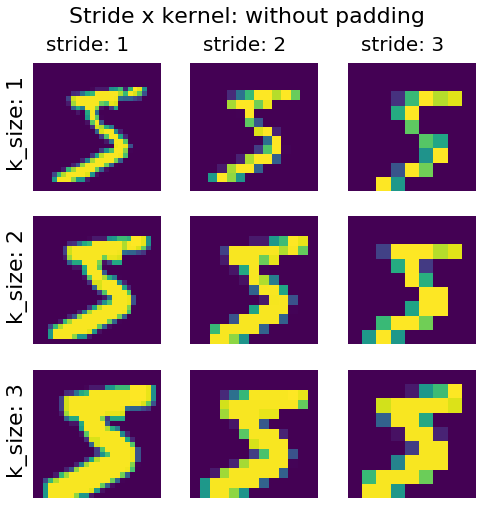

In [11]:
fig, ax = plt.subplots(
    ncols=3, nrows=3, figsize=(8,8))
fig.suptitle(
    "Stride x kernel: without padding",
    fontsize=22, x=0.5, y=.95, va="baseline"
)
for size in range(3):
    for stride in range(3):
        axe = ax[size][stride]
        axe.set_axis_off()
        axe.imshow(max_pool(
            train_img[0].squeeze(),
            size = size+1,
            stride = stride+1,
            padding=False))
        if size==0: plt.text(
            0.1, 1.1, f"stride: {stride+1}",
            rotation=0, fontsize=20,
            transform=axe.transAxes)
        if stride==0: plt.text(
            -0.2, 0.2, f"k_size: {size+1}",
            rotation=90, fontsize=22,
            transform=axe.transAxes)

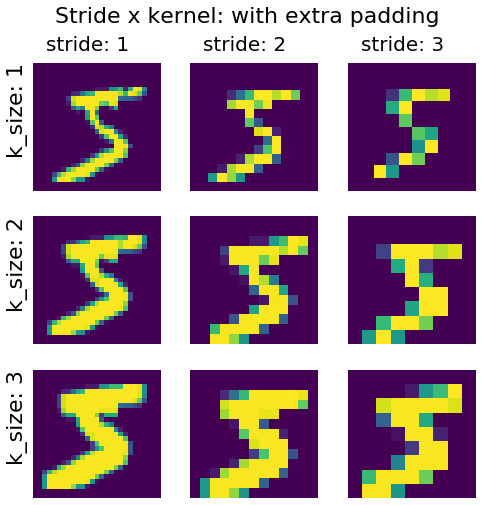

In [12]:
fig, ax = plt.subplots(
    ncols=3, nrows=3, figsize=(8,8))
fig.suptitle(
    "Stride x kernel: with extra padding",
    fontsize=22, x=0.5, y=.95, va="baseline"
)
for size in range(3):
    for stride in range(3):
        axe = ax[size][stride]
        axe.set_axis_off()
        axe.imshow(max_pool(
            train_img[0].squeeze(),
            size = size+1,
            stride = stride+1,
            padding=True))
        if size==0: plt.text(
            0.1, 1.1, f"stride: {stride+1}",
            rotation=0, fontsize=20,
            transform=axe.transAxes)
        if stride==0: plt.text(
            -0.2, 0.3, f"k_size: {size+1}",
            rotation=90, fontsize=22,
            transform=axe.transAxes)

### First adding some padding to the digit preserves shape after a couple pools or filters

# Edge detection and pressure detection filter
- First 3 are without blur
- Last 3 are 

Utilizing the old padding method

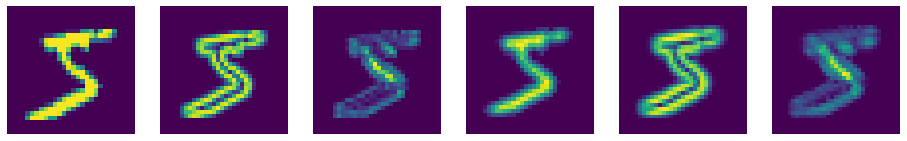

In [386]:
for img in train_img[:1]:
    fig, ax = plt.subplots(ncols=6, figsize=(16,5))
    [ax[i].set_axis_off() for i in range(6)]
    padded = pad(img,3)
    ax[0].imshow(img)
    ax[1].imshow(edge_detection(padded))
    ax[2].imshow(pressure_detection(padded))
    img = blur(pad(img,2))
    ax[3].imshow(img)
    padded = (pad(img,2))
    ax[4].imshow(edge_detection(padded))
    ax[5].imshow(pressure_detection(padded))
    plt.show()

# How small should the final image be?

**4x4** seems optimal for *performance* but the **7x7** has more *features*

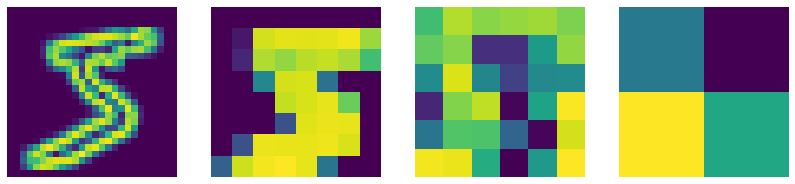

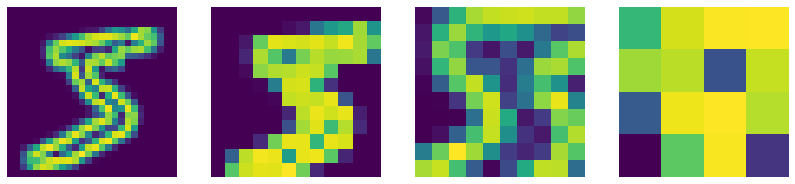

In [20]:
edge_detect_sequence = [
    lambda x:edge_detection(x),
    lambda x:max_pool(x, 3,3),
    lambda x:edge_detection(x),
    lambda x:max_pool(x, 2,2),
]
edge_detect_sequence_2 = [
    lambda x:edge_detection(x),
    lambda x:max_pool(x, 2,2),
    lambda x:edge_detection(x),
    lambda x:max_pool(x, 2,2),
]
def apply(image, sequence):
    for seq in sequence:
        image = seq(image)
    return image

def visualize_filters(image: np.array, sequence):    
    fig, ax = plt.subplots(
        ncols=len(sequence), figsize=(14,5))
    for idx, action in enumerate(sequence):
        image = action(image)
        ax[idx].set_axis_off()
        ax[idx].imshow(image)
    plt.show()
    
visualize_filters(train_img[0].squeeze(), edge_detect_sequence)
visualize_filters(train_img[0].squeeze(), edge_detect_sequence_2)

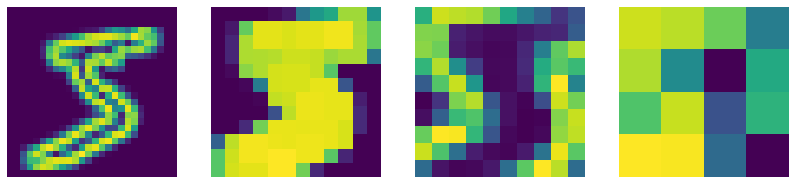

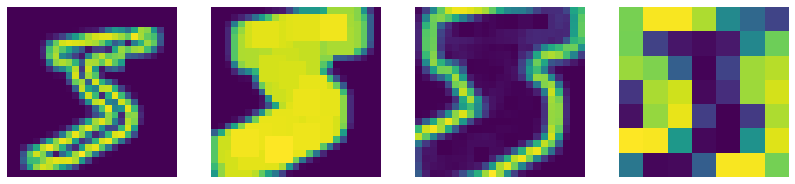

In [24]:
edge_detect_sequence = [
    lambda x:edge_detection(x),
    lambda x:max_pool(x, 4,2),
    lambda x:edge_detection(x),
    lambda x:max_pool(x, 2,2),
]
edge_detect_sequence_2 = [
    lambda x:edge_detection(x),
    lambda x:max_pool(x, 4,1),
    lambda x:edge_detection(x),
    lambda x:max_pool(x, 3,3),
]
def apply(image, sequence):
    for seq in sequence:
        image = seq(image)
    return image

def visualize_filters(image: np.array, sequence):    
    fig, ax = plt.subplots(
        ncols=len(sequence), figsize=(14,5))
    for idx, action in enumerate(sequence):
        image = action(image)
        ax[idx].set_axis_off()
        ax[idx].imshow(image)
    plt.show()
    
visualize_filters(train_img[0].squeeze(), edge_detect_sequence)
visualize_filters(train_img[0].squeeze(), edge_detect_sequence_2)

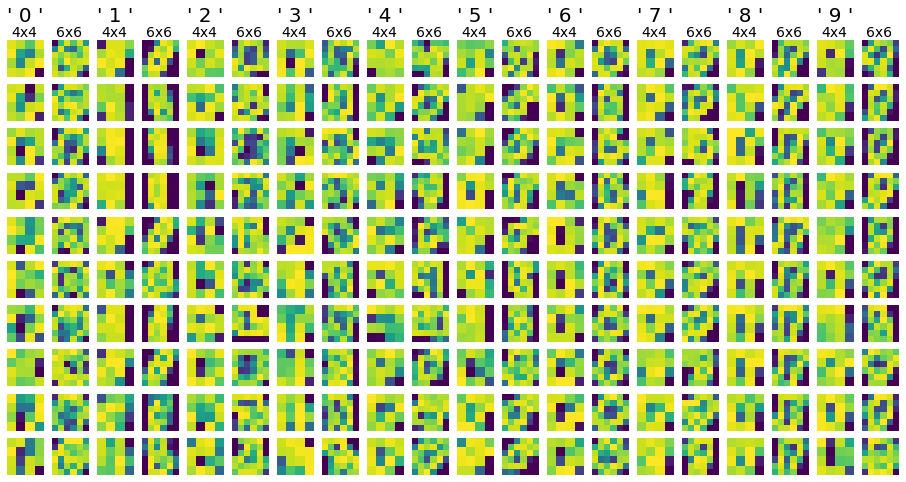

In [97]:
fig, ax = plt.subplots(
    ncols=20, nrows=10,
    figsize=(16,8))
[
    ax[y][x].set_axis_off() 
     for y in range(10)
      for x in range(20)
]
for label in labeled:
    [
        (
            ax[cnt][label*2].imshow(apply(img, edge_detect_sequence)),
            ax[cnt][label*2+1].imshow(apply(img, edge_detect_sequence_2))
        )
        for cnt, img in enumerate(labeled[label][:10]) 
    ]
    plt.text(
        0, 1.5, f"' {str(label)} '",
        rotation=0, fontsize=20,
        transform=ax[0][label*2].transAxes
    )    
    plt.text(
        .1, 1.1, "4x4",
        rotation=0, fontsize=14,
        transform=ax[0][label*2].transAxes
    )    
    plt.text(
        .1, 1.1, "6x6",
        rotation=0, fontsize=14,
        transform=ax[0][label*2+1].transAxes
    )
plt.show()

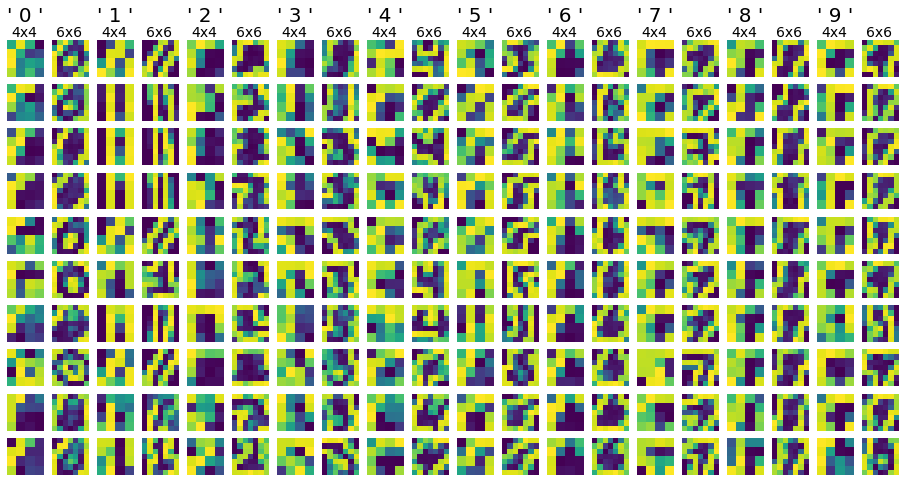

In [25]:
fig, ax = plt.subplots(
    ncols=20, nrows=10,
    figsize=(16,8))
[
    ax[y][x].set_axis_off() 
     for y in range(10)
      for x in range(20)
]
for label in labeled:
    [
        (
            ax[cnt][label*2].imshow(apply(img, edge_detect_sequence)),
            ax[cnt][label*2+1].imshow(apply(img, edge_detect_sequence_2))
        )
        for cnt, img in enumerate(labeled[label][:10]) 
    ]
    plt.text(
        0, 1.5, f"' {str(label)} '",
        rotation=0, fontsize=20,
        transform=ax[0][label*2].transAxes
    )    
    plt.text(
        .1, 1.1, "4x4",
        rotation=0, fontsize=14,
        transform=ax[0][label*2].transAxes
    )    
    plt.text(
        .1, 1.1, "6x6",
        rotation=0, fontsize=14,
        transform=ax[0][label*2+1].transAxes
    )
plt.show()

# Mnest with ImageDataGenerator preprocessing_function

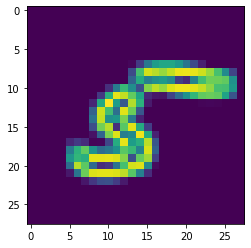

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dropout, Dense
)

def gen_train_images(batch_size = 10, target_size=(26,26)):
    data_generator = ImageDataGenerator(
        preprocessing_function=lambda x:pad(edge_detection(x.squeeze()))[...,None])
    data_generator.fit(train_img[...,None])
    return data_generator.flow(
        train_img[...,None],
        train_lbl[...,None],
        batch_size)

plt.imshow(gen_train_images()[0][0][0].squeeze())
plt.show()

# Extra

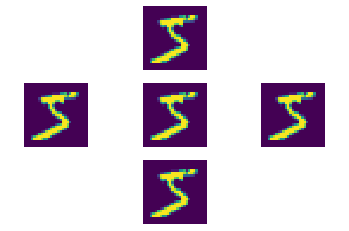

In [102]:
stride = 1
image = train_img[0].squeeze()
fig, ax = plt.subplots(nrows=3, ncols=3)
[
    ax[y][x].set_axis_off() 
    for x,y in np.ndindex(ax.shape)
]
positions=[(1,1),(1,0),(0,1),(1,2),(2,1)]
[
    ax[pos[0]][pos[1]].imshow(image[
        1::stride,
        1::stride
    ])for pos in positions
]
plt.show()

Kernel=1 Stride=1 to 5


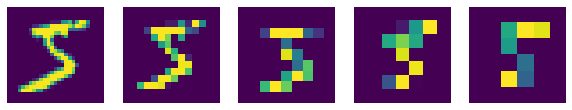

In [101]:
image = train_img[0].squeeze()
fig, ax = plt.subplots(
    ncols=5, figsize=(10,3))
[ax[x].set_axis_off() 
 for x in range(len(ax))]
[ax[stride].imshow(
    image[1::stride+1,1::stride+1])
 for stride in range(0,5)]
print("Kernel=1 Stride=1 to 5")
plt.show()